In [1]:
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm
import json
import os
from gemini_multiagent_framework import GeminiAgent
from openai_multiagent_framework import OpenAIAgent
from datasets import load_dataset
import pandas as pd
from benchmarks_utils import *

## AGENTCODER VERSION 2

## Main differences from version 0 
- it regenerates tests (in even iterations of the optimization loop, alternating with the optimization of the code);
- prompts different from those of the "Agent Coder" paper.

In [2]:

def generate_code_v2(entry, code_writer, prompt_path = "./prompts_v2/codewriter_prompt.md"):
    with open(prompt_path, "r") as f:
        code_writer_prompt = f.read()
    
    requirement = entry["prompt"]
    
    prompt = f"""
{code_writer_prompt}
```python
{requirement}
```
"""
    res = code_writer.process_message(message=prompt)
    code = extract_code(res) 
    entry["generated_code"] = code
    log_file("-" * 20 + "[CODE WRITER PROMPT]"+ "-" * 20 + "\n"+prompt, "log.txt") # DEBUG
    log_file("-" * 20 + "[CODE WRITER RESPONSE]"+ "-" * 20 + "\n"+res, "log.txt") # DEBUG
    return entry

def generate_code_v2_mbpp(entry, code_writer, prompt_path = "./prompts_v2/codewriter_prompt_mbpp.md"):
    with open(prompt_path, "r") as f:
        code_writer_prompt = f.read()
    
    requirement = entry["prompt"]
    
    prompt = f"""
{code_writer_prompt}
{requirement}
Signature of the function: {extract_signature(entry["code"])}
"""
    res = code_writer.process_message(message=prompt)
    code = extract_code(res) 
    entry["generated_code"] = code
    log_file("-" * 20 + "[CODE WRITER PROMPT]"+ "-" * 20 + "\n"+prompt, "log.txt") # DEBUG
    log_file("-" * 20 + "[CODE WRITER RESPONSE]"+ "-" * 20 + "\n"+res, "log.txt") # DEBUG
    return entry


def process_entry(entry, max_attempts = 3):
    entry = generate_code_v2(entry, code_writer)
    entry = generate_tests(entry, test_writer, prompt_path="./prompts_v2/testwriter_prompt.md")#, different_test_writer=gpt4_agent)
    #entry = validate_code(entry, code_writer, max_attempts=3)
   
   # main difference: set test_regeneration to True
    entry = iterate_tests(entry, code_writer, max_attempts, 
                          prompt_path="./prompts_v2/codewriter_fix.md", test_regeneration=True, intermediate_results=True,
                          reg_prompt_path = "./prompts_v2/testwriter_fix.md", test_writer=test_writer)
    entry = check_solution(entry)
    entry = generate_report(entry)
    return entry

def get_last_valid_count(entry, current_iteration, count_type):
    for i in range(current_iteration, -1, -1):
        key = f"{count_type}_{i}"
        if key in entry:
            return entry[key]
    return 0  # Return 0 if no valid count is found


## MODIFY THIS FUNCTION TO  PRINT HAVE THE INTERMEDIATE RESULTS OVER MORE ITERATIONS
def process_dataset(dataset, chunk_size, max_workers, max_attempts, intermediate_results=False):
    """
    Processes the dataset in chunks with multithreading.

    Parameters:
    dataset (list): The dataset to be processed.
    chunk_size (int): Number of entries per chunk.
    max_workers (int): Maximum number of worker threads.
    max_attempts (int): Maximum number of attempts for processing each entry.

    Returns:
    list: All processed results.
    """
    all_results = []

    for chunk in tqdm(chunk_dataset(dataset, chunk_size), desc="Processing Chunks"):
        with ThreadPoolExecutor(max_workers=max_workers) as executor:
            results = list(executor.map(lambda entry: process_entry(entry, max_attempts), chunk))
            all_results.extend(results)
            
    for entry in all_results:
        print(entry["report"])

    if intermediate_results:
        for i in range(max_attempts + 1):
            valid_key = f"valid_{i}"
            valid_solutions = [entry for entry in all_results if (valid_key in entry and entry[valid_key]) or
                                (valid_key not in entry and entry["solution_valid"])]
            num_true_values = len(valid_solutions)
            accuracy = num_true_values / len(dataset) * 100
            print(f"Iteration {i}: {num_true_values} true values over {len(dataset)} (Accuracy: {accuracy:.2f}%)\n")
    
    # Sum the total test count and overall count, considering previous iterations if necessary
            total_test_count = sum([get_last_valid_count(entry, i, "test_count") for entry in all_results])
            overall_count = sum([get_last_valid_count(entry, i, "test_total") for entry in all_results])
    
    # Print the accuracy for the iteration of the tests
            if overall_count > 0:
                print(f"Test accuracy for iteration {i}: {total_test_count}/{overall_count} ({total_test_count/overall_count*100:.2f}%)")
            else:
                print(f"Test accuracy for iteration {i}: No valid tests found")
                            
            
        return all_results
        
            
    valid_solutions = [entry for entry in all_results if entry["solution_valid"]]
    # Print the number of valid solutions as a percentage of the total number of solutions
    print(f"Number of valid solutions: {len(valid_solutions)}/{len(all_results)}")
    print(f"Percentage of valid solutions: {len(valid_solutions) / len(all_results) * 100:.2f}%")

    return all_results


def process_entry_mbpp(entry, max_attempts = 3):
    entry = generate_code_v2_mbpp(entry, code_writer, prompt_path="./prompts_v2/codewriter_prompt_mbpp.md")
    entry = generate_tests_mbpp(entry, test_writer, prompt_path="./prompts_v2/testwriter_prompt_mbpp.md")
   # entry = validate_code(entry, code_writer, max_attempts=1)
    entry = iterate_tests(entry, code_writer, max_attempts,
                          prompt_path="./prompts_v2/codewriter_fix_mbpp.md", 
                          test_regeneration=True, intermediate_results=True, mbpp = True, 
                          reg_prompt_path = "./prompts_v2/testwriter_fix_mbpp.md", test_writer=test_writer)
    entry = check_solution_mbpp(entry)
    entry = generate_report(entry)
    return entry


def process_dataset_mbpp(dataset, chunk_size, max_workers, max_attempts, intermediate_results=False):
    """
    Processes the dataset in chunks with multithreading.

    Parameters:
    dataset (list): The dataset to be processed.
    chunk_size (int): Number of entries per chunk.
    max_workers (int): Maximum number of worker threads.
    max_attempts (int): Maximum number of attempts for processing each entry.

    Returns:
    list: All processed results.
    """
    all_results = []

    for chunk in tqdm(chunk_dataset(dataset, chunk_size), desc="Processing Chunks"):
        with ThreadPoolExecutor(max_workers=max_workers) as executor:
            results = list(executor.map(lambda entry: process_entry_mbpp(entry, max_attempts), chunk))
            all_results.extend(results)
            
    for entry in all_results:
        print(entry["report"])
     
    if intermediate_results:
        for i in range(max_attempts + 1):
            valid_key = f"valid_{i}"
            valid_solutions = [entry for entry in all_results if (valid_key in entry and entry[valid_key]) or 
                                   (valid_key not in entry and entry["solution_valid"])]
            num_true_values = len(valid_solutions)
            accuracy = num_true_values / len(dataset) * 100
            # write to a file the intermediate results
            print(f"Iteration {i}: {num_true_values} true values over {len(dataset)} (Accuracy: {accuracy:.2f}%)\n")
        return all_results


    valid_solutions = [entry for entry in all_results if entry["solution_valid"]]
    # Print the number of valid solutions as a percentage of the total number of solutions
    print(f"Number of valid solutions: {len(valid_solutions)}/{len(all_results)}")
    print(f"Percentage of valid solutions: {len(valid_solutions) / len(all_results) * 100:.2f}%")

    return all_results

## HUMANEVAL Benchmark

In [3]:
dataset = load_dataset("openai_humaneval", split="test")
dataset = [entry for entry in dataset]
dataset_chunks = list(chunk_dataset(dataset, 55))


## Experiment: try to regenerate the tests only in the first two iterations
Check the correctness of the generated tests only twice in the first two iterations and then take them for granted in the following ones (obtained by modifying an if condition in the benchmarks_utils.py file, not always executable directly)

In [4]:
max_attempts = 6
_, code_writer, test_writer = instantiate_agents_gpt(model="gpt-4o-mini")
results = process_dataset(dataset_chunks[2], chunk_size=20, max_workers=20, max_attempts=max_attempts, intermediate_results=True)


Processing Chunks: 3it [03:52, 77.60s/it]


Report:
- Total tests: 5
- Passed tests: 5
- Failed tests: 0
- Percentage passed: 100.0%

Solution is valid: False


Report:
- Total tests: 5
- Passed tests: 5
- Failed tests: 0
- Percentage passed: 100.0%

Solution is valid: True


Report:
- Total tests: 5
- Passed tests: 5
- Failed tests: 0
- Percentage passed: 100.0%

Solution is valid: True


Report:
- Total tests: 5
- Passed tests: 5
- Failed tests: 0
- Percentage passed: 100.0%

Solution is valid: True


Report:
- Total tests: 5
- Passed tests: 5
- Failed tests: 0
- Percentage passed: 100.0%

Solution is valid: True


Report:
- Total tests: 5
- Passed tests: 5
- Failed tests: 0
- Percentage passed: 100.0%

Solution is valid: False


Report:
- Total tests: 5
- Passed tests: 4
- Failed tests: 1
- Percentage passed: 80.0%

Solution is valid: True


Report:
- Total tests: 5
- Passed tests: 5
- Failed tests: 0
- Percentage passed: 100.0%

Solution is valid: True


Report:
- Total tests: 5
- Passed tests: 5
- Failed tests: 0
- Percent

## Varying number of test cases

In [5]:
max_attempts = 6
_, code_writer, test_writer = instantiate_agents_gpt(model="gpt-4o-mini")
results = process_dataset(dataset_chunks[2], chunk_size=20, max_workers=20, max_attempts=max_attempts, intermediate_results=True)


Processing Chunks: 3it [04:27, 89.27s/it] 


Report:
- Total tests: 15
- Passed tests: 15
- Failed tests: 0
- Percentage passed: 100.0%

Solution is valid: False


Report:
- Total tests: 13
- Passed tests: 13
- Failed tests: 0
- Percentage passed: 100.0%

Solution is valid: True


Report:
- Total tests: 15
- Passed tests: 15
- Failed tests: 0
- Percentage passed: 100.0%

Solution is valid: False


Report:
- Total tests: 10
- Passed tests: 9
- Failed tests: 1
- Percentage passed: 90.0%

Solution is valid: True


Report:
- Total tests: 15
- Passed tests: 12
- Failed tests: 3
- Percentage passed: 80.0%

Solution is valid: True


Report:
- Total tests: 10
- Passed tests: 9
- Failed tests: 1
- Percentage passed: 90.0%

Solution is valid: True


Report:
- Total tests: 11
- Passed tests: 9
- Failed tests: 2
- Percentage passed: 81.81818181818183%

Solution is valid: False


Report:
- Total tests: 12
- Passed tests: 8
- Failed tests: 4
- Percentage passed: 66.66666666666666%

Solution is valid: True


Report:
- Total tests: 15
- Passed 

## GPT 3.5 Turbo

In [23]:
_, _, gpt4_agent = instantiate_agents_gpt(model="gpt-4o")
max_attempts = 5
_, code_writer, test_writer = instantiate_agents_gpt(model="gpt-3.5-turbo")
results = process_dataset(dataset_chunks[0], chunk_size=20, max_workers=20, max_attempts=max_attempts, intermediate_results=True)


Processing Chunks: 3it [01:09, 23.08s/it]


Report:
- Total tests: 5
- Passed tests: 5
- Failed tests: 0
- Percentage passed: 100.0%

Solution is valid: True


Report:
- Total tests: 5
- Passed tests: 2
- Failed tests: 3
- Percentage passed: 40.0%

Solution is valid: False


Report:
- Total tests: 5
- Passed tests: 5
- Failed tests: 0
- Percentage passed: 100.0%

Solution is valid: True


Report:
- Total tests: 5
- Passed tests: 5
- Failed tests: 0
- Percentage passed: 100.0%

Solution is valid: True


Report:
- Total tests: 5
- Passed tests: 4
- Failed tests: 1
- Percentage passed: 80.0%

Solution is valid: True


Report:
- Total tests: 5
- Passed tests: 5
- Failed tests: 0
- Percentage passed: 100.0%

Solution is valid: True


Report:
- Total tests: 5
- Passed tests: 5
- Failed tests: 0
- Percentage passed: 100.0%

Solution is valid: True


Report:
- Total tests: 5
- Passed tests: 5
- Failed tests: 0
- Percentage passed: 100.0%

Solution is valid: True


Report:
- Total tests: 5
- Passed tests: 5
- Failed tests: 0
- Percentag

In [24]:
# chunk 2 results
print("Total tokens test creator: {}".format(gpt4_agent.total_tokens))
print("Total tokens code writer: {}".format(code_writer.total_tokens))
print("Total tokens test writer: {}".format(test_writer.total_tokens))
print("Total tokens: {}".format(code_writer.total_tokens + test_writer.total_tokens))
print("Code writer API calls: {}".format(test_writer.api_calls))
print("Code writer API calls: {}".format(code_writer.api_calls))
print("Total API calls: {}".format(code_writer.api_calls + test_writer.api_calls))

Total tokens test creator: 41240
Total tokens code writer: 117962
Total tokens test writer: 44961
Total tokens: 162923
Code writer API calls: 51
Code writer API calls: 85
Total API calls: 136


In [25]:
_, _, gpt4_agent = instantiate_agents_gpt(model="gpt-4o")
max_attempts = 5
_, code_writer, test_writer = instantiate_agents_gpt(model="gpt-3.5-turbo")
results = process_dataset(dataset_chunks[1], chunk_size=20, max_workers=20, max_attempts=max_attempts, intermediate_results=True)


Processing Chunks: 3it [00:57, 19.29s/it]


Report:
- Total tests: 5
- Passed tests: 5
- Failed tests: 0
- Percentage passed: 100.0%

Solution is valid: True


Report:
- Total tests: 5
- Passed tests: 5
- Failed tests: 0
- Percentage passed: 100.0%

Solution is valid: True


Report:
- Total tests: 5
- Passed tests: 5
- Failed tests: 0
- Percentage passed: 100.0%

Solution is valid: True


Report:
- Total tests: 5
- Passed tests: 5
- Failed tests: 0
- Percentage passed: 100.0%

Solution is valid: True


Report:
- Total tests: 5
- Passed tests: 5
- Failed tests: 0
- Percentage passed: 100.0%

Solution is valid: True


Report:
- Total tests: 5
- Passed tests: 5
- Failed tests: 0
- Percentage passed: 100.0%

Solution is valid: True


Report:
- Total tests: 5
- Passed tests: 5
- Failed tests: 0
- Percentage passed: 100.0%

Solution is valid: True


Report:
- Total tests: 5
- Passed tests: 5
- Failed tests: 0
- Percentage passed: 100.0%

Solution is valid: True


Report:
- Total tests: 5
- Passed tests: 5
- Failed tests: 0
- Percenta

In [26]:
# chunk 2 results
print("Total tokens test creator: {}".format(gpt4_agent.total_tokens))
print("Total tokens code writer: {}".format(code_writer.total_tokens))
print("Total tokens test writer: {}".format(test_writer.total_tokens))
print("Total tokens: {}".format(code_writer.total_tokens + test_writer.total_tokens))
print("Code writer API calls: {}".format(test_writer.api_calls))
print("Code writer API calls: {}".format(code_writer.api_calls))
print("Total API calls: {}".format(code_writer.api_calls + test_writer.api_calls))

Total tokens test creator: 42213
Total tokens code writer: 117602
Total tokens test writer: 36875
Total tokens: 154477
Code writer API calls: 46
Code writer API calls: 83
Total API calls: 129


In [27]:
_, _, gpt4_agent = instantiate_agents_gpt(model="gpt-4o")
max_attempts = 5
_, code_writer, test_writer = instantiate_agents_gpt(model="gpt-3.5-turbo")
results = process_dataset(dataset_chunks[2], chunk_size=20, max_workers=20, max_attempts=max_attempts, intermediate_results=True)


Processing Chunks: 3it [02:34, 51.45s/it]


Report:
- Total tests: 5
- Passed tests: 5
- Failed tests: 0
- Percentage passed: 100.0%

Solution is valid: True


Report:
- Total tests: 5
- Passed tests: 5
- Failed tests: 0
- Percentage passed: 100.0%

Solution is valid: True


Report:
- Total tests: 5
- Passed tests: 5
- Failed tests: 0
- Percentage passed: 100.0%

Solution is valid: True


Report:
- Total tests: 8
- Passed tests: 3
- Failed tests: 5
- Percentage passed: 37.5%

Solution is valid: False


Report:
- Total tests: 5
- Passed tests: 5
- Failed tests: 0
- Percentage passed: 100.0%

Solution is valid: True


Report:
- Total tests: 5
- Passed tests: 4
- Failed tests: 1
- Percentage passed: 80.0%

Solution is valid: False


Report:
- Total tests: 5
- Passed tests: 5
- Failed tests: 0
- Percentage passed: 100.0%

Solution is valid: True


Report:
- Total tests: 5
- Passed tests: 5
- Failed tests: 0
- Percentage passed: 100.0%

Solution is valid: True


Report:
- Total tests: 5
- Passed tests: 5
- Failed tests: 0
- Percenta

In [29]:
# chunk 2 results
print("Total tokens test creator: {}".format(gpt4_agent.total_tokens))
print("Total tokens code writer: {}".format(code_writer.total_tokens))
print("Total tokens test writer: {}".format(test_writer.total_tokens))
print("Total tokens: {}".format(code_writer.total_tokens + test_writer.total_tokens))
print("Code writer API calls: {}".format(test_writer.api_calls))
print("Code writer API calls: {}".format(code_writer.api_calls))
print("Total API calls: {}".format(code_writer.api_calls + test_writer.api_calls))

Total tokens test creator: 43336
Total tokens code writer: 152426
Total tokens test writer: 72257
Total tokens: 224683
Code writer API calls: 66
Code writer API calls: 93
Total API calls: 159


## GPT 4o mini

In [18]:
_, _, gpt4_agent = instantiate_agents_gpt(model="gpt-4o")
max_attempts = 5
_, code_writer, test_writer = instantiate_agents_gpt(model="gpt-4o-mini")
results = process_dataset(dataset_chunks[0], chunk_size=20, max_workers=20, max_attempts=max_attempts, intermediate_results=True)


Processing Chunks: 3it [02:27, 49.14s/it]


Report:
- Total tests: 5
- Passed tests: 5
- Failed tests: 0
- Percentage passed: 100.0%

Solution is valid: True


Report:
- Total tests: 5
- Passed tests: 4
- Failed tests: 1
- Percentage passed: 80.0%

Solution is valid: True


Report:
- Total tests: 5
- Passed tests: 3
- Failed tests: 2
- Percentage passed: 60.0%

Solution is valid: True


Report:
- Total tests: 5
- Passed tests: 5
- Failed tests: 0
- Percentage passed: 100.0%

Solution is valid: True


Report:
- Total tests: 5
- Passed tests: 5
- Failed tests: 0
- Percentage passed: 100.0%

Solution is valid: True


Report:
- Total tests: 5
- Passed tests: 5
- Failed tests: 0
- Percentage passed: 100.0%

Solution is valid: True


Report:
- Total tests: 5
- Passed tests: 5
- Failed tests: 0
- Percentage passed: 100.0%

Solution is valid: True


Report:
- Total tests: 5
- Passed tests: 5
- Failed tests: 0
- Percentage passed: 100.0%

Solution is valid: True


Report:
- Total tests: 5
- Passed tests: 5
- Failed tests: 0
- Percentage

In [19]:
# chunk 2 results
print("Total tokens test creator: {}".format(gpt4_agent.total_tokens))
print("Total tokens code writer: {}".format(code_writer.total_tokens))
print("Total tokens test writer: {}".format(test_writer.total_tokens))
print("Total tokens: {}".format(code_writer.total_tokens + test_writer.total_tokens))
print("Code writer API calls: {}".format(test_writer.api_calls))
print("Code writer API calls: {}".format(code_writer.api_calls))
print("Total API calls: {}".format(code_writer.api_calls + test_writer.api_calls))

Total tokens test creator: 40752
Total tokens code writer: 106729
Total tokens test writer: 40314
Total tokens: 147043
Code writer API calls: 40
Code writer API calls: 76
Total API calls: 116


In [14]:
_, _, gpt4_agent = instantiate_agents_gpt(model="gpt-4o")
max_attempts = 5
_, code_writer, test_writer = instantiate_agents_gpt(model="gpt-4o-mini")
results = process_dataset(dataset_chunks[1], chunk_size=20, max_workers=20, max_attempts=max_attempts, intermediate_results=True)


Processing Chunks: 3it [02:46, 55.50s/it]


Report:
- Total tests: 5
- Passed tests: 5
- Failed tests: 0
- Percentage passed: 100.0%

Solution is valid: True


Report:
- Total tests: 5
- Passed tests: 5
- Failed tests: 0
- Percentage passed: 100.0%

Solution is valid: True


Report:
- Total tests: 5
- Passed tests: 5
- Failed tests: 0
- Percentage passed: 100.0%

Solution is valid: True


Report:
- Total tests: 5
- Passed tests: 5
- Failed tests: 0
- Percentage passed: 100.0%

Solution is valid: True


Report:
- Total tests: 5
- Passed tests: 4
- Failed tests: 1
- Percentage passed: 80.0%

Solution is valid: True


Report:
- Total tests: 5
- Passed tests: 5
- Failed tests: 0
- Percentage passed: 100.0%

Solution is valid: True


Report:
- Total tests: 5
- Passed tests: 5
- Failed tests: 0
- Percentage passed: 100.0%

Solution is valid: True


Report:
- Total tests: 5
- Passed tests: 5
- Failed tests: 0
- Percentage passed: 100.0%

Solution is valid: True


Report:
- Total tests: 5
- Passed tests: 5
- Failed tests: 0
- Percentag

In [15]:
# chunk 2 results
print("Total tokens test creator: {}".format(gpt4_agent.total_tokens))
print("Total tokens code writer: {}".format(code_writer.total_tokens))
print("Total tokens test writer: {}".format(test_writer.total_tokens))
print("Total tokens: {}".format(code_writer.total_tokens + test_writer.total_tokens))
print("Code writer API calls: {}".format(test_writer.api_calls))
print("Code writer API calls: {}".format(code_writer.api_calls))
print("Total API calls: {}".format(code_writer.api_calls + test_writer.api_calls))

Total tokens test creator: 42128
Total tokens code writer: 141335
Total tokens test writer: 64767
Total tokens: 206102
Code writer API calls: 61
Code writer API calls: 90
Total API calls: 151


In [7]:
_, _, gpt4_agent = instantiate_agents_gpt(model="gpt-4o")
max_attempts = 5
_, code_writer, test_writer = instantiate_agents_gpt(model="gpt-4o-mini")
results = process_dataset(dataset_chunks[2], chunk_size=20, max_workers=20, max_attempts=max_attempts, intermediate_results=True)


Processing Chunks: 3it [02:56, 58.92s/it]


Report:
- Total tests: 5
- Passed tests: 5
- Failed tests: 0
- Percentage passed: 100.0%

Solution is valid: True


Report:
- Total tests: 5
- Passed tests: 5
- Failed tests: 0
- Percentage passed: 100.0%

Solution is valid: True


Report:
- Total tests: 5
- Passed tests: 5
- Failed tests: 0
- Percentage passed: 100.0%

Solution is valid: True


Report:
- Total tests: 5
- Passed tests: 5
- Failed tests: 0
- Percentage passed: 100.0%

Solution is valid: True


Report:
- Total tests: 5
- Passed tests: 5
- Failed tests: 0
- Percentage passed: 100.0%

Solution is valid: True


Report:
- Total tests: 5
- Passed tests: 5
- Failed tests: 0
- Percentage passed: 100.0%

Solution is valid: False


Report:
- Total tests: 5
- Passed tests: 4
- Failed tests: 1
- Percentage passed: 80.0%

Solution is valid: True


Report:
- Total tests: 5
- Passed tests: 4
- Failed tests: 1
- Percentage passed: 80.0%

Solution is valid: True


Report:
- Total tests: 5
- Passed tests: 5
- Failed tests: 0
- Percentag

In [ ]:
# chunk 2 results
print("Total tokens test creator: {}".format(gpt4_agent.total_tokens))
print("Total tokens code writer: {}".format(code_writer.total_tokens))
print("Total tokens test writer: {}".format(test_writer.total_tokens))
print("Total tokens: {}".format(code_writer.total_tokens + test_writer.total_tokens))
print("Code writer API calls: {}".format(test_writer.api_calls))
print("Code writer API calls: {}".format(code_writer.api_calls))
print("Total API calls: {}".format(code_writer.api_calls + test_writer.api_calls))

Total tokens test creator: 43264
Total tokens code writer: 154362
Total tokens test writer: 72138
Total tokens: 226500
Code writer API calls: 66
Code writer API calls: 94
Total API calls: 160


## What is the overall trend of the optimization loop?

In [4]:
dataset = load_dataset("openai_humaneval", split="test")
dataset = [entry for entry in dataset]
dataset_chunks = list(chunk_dataset(dataset, 55))


In [33]:
# try with 13 iterations
_, _, gpt4_agent = instantiate_agents_gpt(model="gpt-4o-mini")
max_attempts = 13
_, code_writer, test_writer = instantiate_agents_gpt(model="gpt-4o-mini")
results = process_dataset(dataset_chunks[2], chunk_size=20, max_workers=20, max_attempts=max_attempts, intermediate_results=True)


Processing Chunks: 3it [05:47, 115.69s/it]


Report:
- Total tests: 5
- Passed tests: 5
- Failed tests: 0
- Percentage passed: 100.0%

Solution is valid: True


Report:
- Total tests: 5
- Passed tests: 5
- Failed tests: 0
- Percentage passed: 100.0%

Solution is valid: True


Report:
- Total tests: 5
- Passed tests: 5
- Failed tests: 0
- Percentage passed: 100.0%

Solution is valid: True


Report:
- Total tests: 5
- Passed tests: 5
- Failed tests: 0
- Percentage passed: 100.0%

Solution is valid: True


Report:
- Total tests: 5
- Passed tests: 5
- Failed tests: 0
- Percentage passed: 100.0%

Solution is valid: True


Report:
- Total tests: 5
- Passed tests: 5
- Failed tests: 0
- Percentage passed: 100.0%

Solution is valid: True


Report:
- Total tests: 5
- Passed tests: 5
- Failed tests: 0
- Percentage passed: 100.0%

Solution is valid: True


Report:
- Total tests: 5
- Passed tests: 5
- Failed tests: 0
- Percentage passed: 100.0%

Solution is valid: True


Report:
- Total tests: 5
- Passed tests: 5
- Failed tests: 0
- Percenta

In [34]:
# chunk 2 results
print("Total tokens test creator: {}".format(gpt4_agent.total_tokens))
print("Total tokens code writer: {}".format(code_writer.total_tokens))
print("Total tokens test writer: {}".format(test_writer.total_tokens))
print("Total tokens: {}".format(code_writer.total_tokens + test_writer.total_tokens))
print("Code writer API calls: {}".format(test_writer.api_calls))
print("Code writer API calls: {}".format(code_writer.api_calls))
print("Total API calls: {}".format(code_writer.api_calls + test_writer.api_calls))

Total tokens test creator: 43008
Total tokens code writer: 246862
Total tokens test writer: 116910
Total tokens: 363772
Code writer API calls: 107
Code writer API calls: 141
Total API calls: 248


## Comparison GPT 4o mini vs 3.5 Turbo

                   
| Model   | it. 0|  it. 1 |  it. 2 |  Total tokens
| --------------   | ----------   |------------|------------|------------|
| **GPT 4o-mini** |    86%          |       86.5%   |           **87%**      |       579602     |    
| **GPT 3.5 turbo**   |     77%     |     79%        |  79%            |    **572083**          |



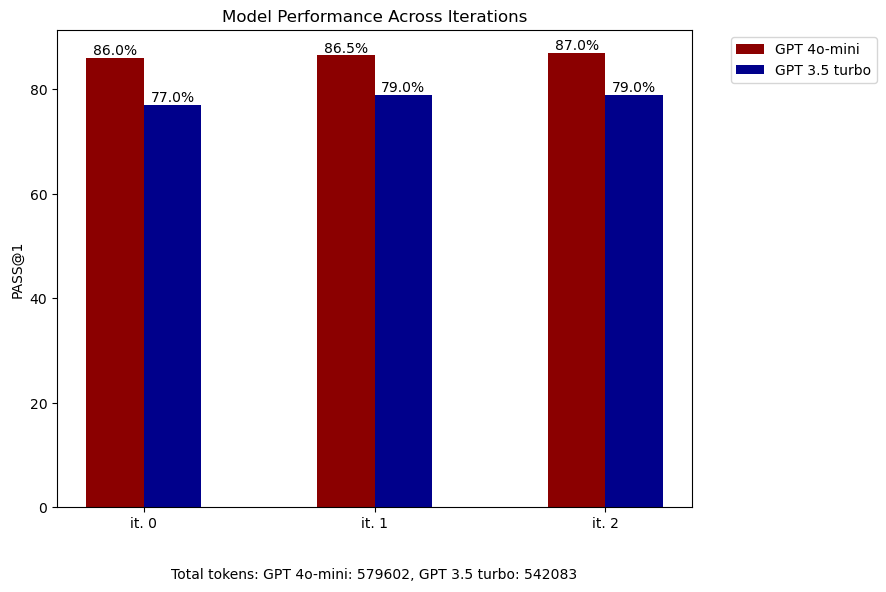

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# Data
models = ['GPT 4o-mini', 'GPT 3.5 turbo']
iterations = ['it. 0', 'it. 1', 'it. 2']
data = np.array([
    [86.0, 86.5, 87.0],
    [77.0, 79.0, 79.0]
])

# Set up the plot
fig, ax = plt.subplots(figsize=(9, 6))  # Increased width to accommodate legend

# Set the width of each bar and the positions of the bars
width = 0.25
x = np.arange(len(iterations))

# Create the bars for each model with new colors
ax.bar(x - width/2, data[0], width, label='GPT 4o-mini', color='darkred')
ax.bar(x + width/2, data[1], width, label='GPT 3.5 turbo', color='darkblue')

# Customize the plot
ax.set_ylabel('PASS@1')
ax.set_title('Model Performance Across Iterations')
ax.set_xticks(x)
ax.set_xticklabels(iterations)

# Move legend outside the plot
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Add value labels on top of each bar
for i in range(len(iterations)):
    for j in range(len(models)):
        ax.text(i + (j-0.5)*width, data[j][i], f'{data[j][i]}%', 
                ha='center', va='bottom')

# Add total tokens as text
ax.text(0.5, -0.15, f'Total tokens: GPT 4o-mini: 579602, GPT 3.5 turbo: 542083', 
        ha='center', transform=ax.transAxes)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

## Comparison between different versions (whole dataset)

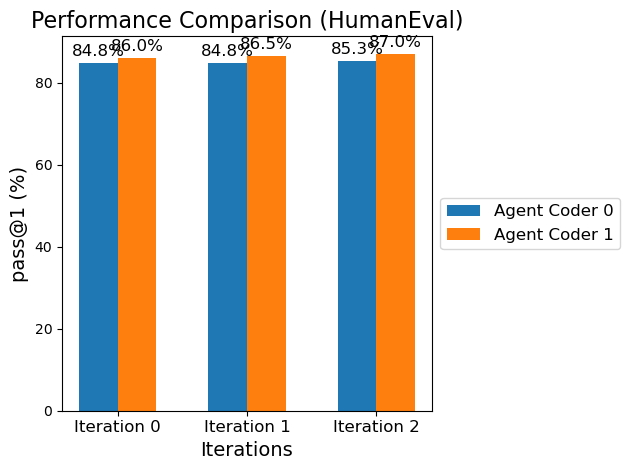

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Data
iterations = ['Iteration 0', 'Iteration 1', 'Iteration 2']
agent_coder_0 = [84.8, 84.8, 85.3]
agent_coder_1 = [86.0, 86.5, 87.0]

# Create a bar plot with tighter bars
bar_width = 0.3  # Reduce the width of the bars
index = np.arange(len(iterations))

fig, ax = plt.subplots()

bar1 = ax.bar(index, agent_coder_0, bar_width, label='Agent Coder 0')
bar2 = ax.bar(index + bar_width, agent_coder_1, bar_width, label='Agent Coder 1')

# Adding labels and title with larger font
ax.set_xlabel('Iterations', fontsize=14)
ax.set_ylabel('pass@1 (%)', fontsize=14)
ax.set_title('Performance Comparison (HumanEval)', fontsize=16)
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(iterations, fontsize=12)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=12)  # Move legend outside

# Adding text labels above the bars
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height}%',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom',
                    fontsize=12)  # Larger font for labels

add_labels(bar1)
add_labels(bar2)

# Show plot with tight layout
plt.tight_layout()
plt.show()



| Version (model:GPT 4o-mini)          | it. 0 |  it. 1  |  it. 2  |  Total tokens |
| -------------- | ----- | ------- | ------- | --------------|
|  **Agent Coder 0**| 84.8%| 84.8%  | 85.3%  | **523544**           |
| **Agent Coder 1** |    86%          |       86.5%   |          **87%**      |       579602     | 

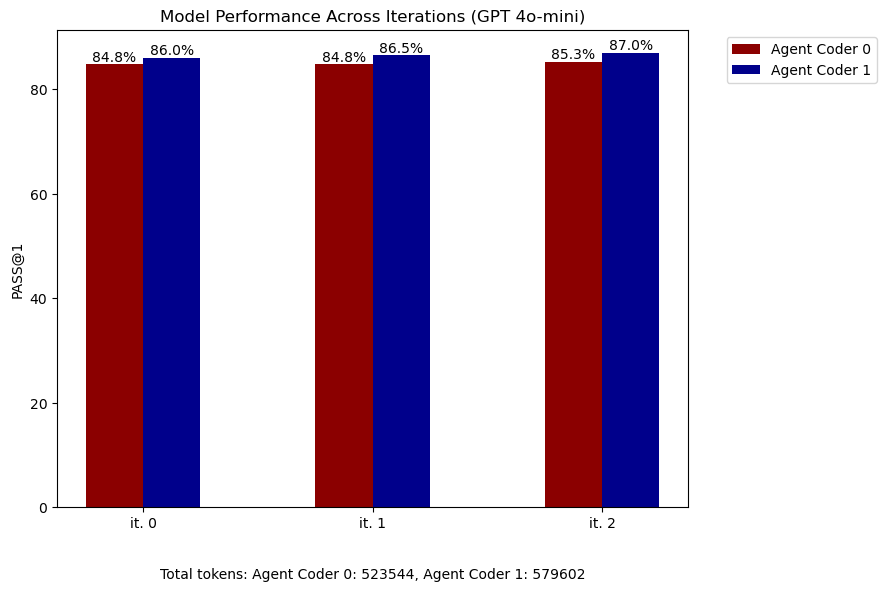

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# Data
models = ['Agent Coder 0', 'Agent Coder 1']
iterations = ['it. 0', 'it. 1', 'it. 2']
data = np.array([
    [84.8, 84.8, 85.3],
    [86.0, 86.5, 87.0]
])

# Set up the plot
fig, ax = plt.subplots(figsize=(9, 6))  # Increased width to accommodate legend

# Set the width of each bar and the positions of the bars
width = 0.25
x = np.arange(len(iterations))

# Create the bars for each model with new colors
ax.bar(x - width/2, data[0], width, label='Agent Coder 0', color='darkred')
ax.bar(x + width/2, data[1], width, label='Agent Coder 1', color='darkblue')

# Customize the plot
ax.set_ylabel('PASS@1')
ax.set_title('Model Performance Across Iterations (GPT 4o-mini)')
ax.set_xticks(x)
ax.set_xticklabels(iterations)

# Move legend outside the plot
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Add value labels on top of each bar
for i in range(len(iterations)):
    for j in range(len(models)):
        ax.text(i + (j-0.5)*width, data[j][i], f'{data[j][i]}%', 
                ha='center', va='bottom')

# Add total tokens as text
ax.text(0.5, -0.15, f'Total tokens: Agent Coder 0: 523544, Agent Coder 1: 579602', 
        ha='center', transform=ax.transAxes)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

## Comparison in the long run

| **Model : GPT 4o-mini**                  | it. 0  |  it. 1  |  it. 2  |  it. 3  |  it. 4  |  it. 5  |  it. 6  |
| ----------------------- | ------ | ------- | ------- | ------- | ------- | ------- | ------- |
|   **Agent Coder 0**          | 79.63% | 75.93%  | 81.48%  | 79.63%  | 75.93%  | 83.33%  | 75.93%  |
| **Agent Coder 1** | 81.48% | 77.78%  | 79.63%  | 79.63%  | 81.48%  | 85.19%  | **85.19%**  |


## MBPP Benchmark

In [6]:
# MBPP dataset preprocessing, import from hugging face
mbpp_dataset = load_dataset("mbpp", "sanitized", split="test")
mbpp_dataset = [entry for entry in mbpp_dataset]
# apply check_solution_mbpp to all entries in the dataset and print the indices of the entries for which entry["solution_valid"] is False
results = [check_correctness(entry) for entry in mbpp_dataset]
# remove the entries for which entry["solution_valid"] is False
mbpp_dataset = [entry for entry in mbpp_dataset if entry["correct"]]


In [7]:
mbpp_dataset_chunks = list(chunk_dataset(mbpp_dataset, 53))

In [8]:
max_attempts = 6
_, code_writer, test_writer = instantiate_agents_gpt(model="gpt-4o-mini")

results = process_dataset_mbpp(mbpp_dataset_chunks[0], chunk_size=25, max_workers=25, 
                               max_attempts=max_attempts, intermediate_results=True)


Processing Chunks: 3it [01:49, 36.61s/it]


Report:
- Total tests: 5
- Passed tests: 1
- Failed tests: 4
- Percentage passed: 20.0%

Solution is valid: True


Report:
- Total tests: 5
- Passed tests: 5
- Failed tests: 0
- Percentage passed: 100.0%

Solution is valid: True


Report:
- Total tests: 5
- Passed tests: 5
- Failed tests: 0
- Percentage passed: 100.0%

Solution is valid: True


Report:
- Total tests: 5
- Passed tests: 5
- Failed tests: 0
- Percentage passed: 100.0%

Solution is valid: True


Report:
- Total tests: 5
- Passed tests: 5
- Failed tests: 0
- Percentage passed: 100.0%

Solution is valid: True


Report:
- Total tests: 5
- Passed tests: 4
- Failed tests: 1
- Percentage passed: 80.0%

Solution is valid: False


Report:
- Total tests: 5
- Passed tests: 5
- Failed tests: 0
- Percentage passed: 100.0%

Solution is valid: True


Report:
- Total tests: 5
- Passed tests: 5
- Failed tests: 0
- Percentage passed: 100.0%

Solution is valid: True


Report:
- Total tests: 5
- Passed tests: 5
- Failed tests: 0
- Percentag

In [9]:
max_attempts = 6
_, code_writer, test_writer = instantiate_agents_gpt(model="gpt-4o-mini")

results = process_dataset_mbpp(mbpp_dataset_chunks[1], chunk_size=25, max_workers=25, 
                               max_attempts=max_attempts, intermediate_results=True)


Processing Chunks: 3it [03:08, 62.91s/it]


Report:
- Total tests: 5
- Passed tests: 5
- Failed tests: 0
- Percentage passed: 100.0%

Solution is valid: True


Report:
- Total tests: 5
- Passed tests: 5
- Failed tests: 0
- Percentage passed: 100.0%

Solution is valid: True


Report:
- Total tests: 5
- Passed tests: 3
- Failed tests: 2
- Percentage passed: 60.0%

Solution is valid: False


Report:
- Total tests: 5
- Passed tests: 4
- Failed tests: 1
- Percentage passed: 80.0%

Solution is valid: True


Report:
- Total tests: 5
- Passed tests: 5
- Failed tests: 0
- Percentage passed: 100.0%

Solution is valid: True


Report:
- Total tests: 5
- Passed tests: 5
- Failed tests: 0
- Percentage passed: 100.0%

Solution is valid: False


Report:
- Total tests: 5
- Passed tests: 5
- Failed tests: 0
- Percentage passed: 100.0%

Solution is valid: True


Report:
- Total tests: 5
- Passed tests: 5
- Failed tests: 0
- Percentage passed: 100.0%

Solution is valid: False


Report:
- Total tests: 5
- Passed tests: 5
- Failed tests: 0
- Percent

In [18]:
print("Total tokens code writer: {}".format(code_writer.total_tokens))
print("Total tokens test writer: {}".format(test_writer.total_tokens))
print("Total tokens: {}".format(code_writer.total_tokens + test_writer.total_tokens))
print("Code writer API calls: {}".format(test_writer.api_calls))
print("Code writer API calls: {}".format(code_writer.api_calls))
print("Total API calls: {}".format(code_writer.api_calls + test_writer.api_calls))

Total tokens code writer: 19236
Total tokens test writer: 7413
Total tokens: 26649
Code writer API calls: 8
Code writer API calls: 16
Total API calls: 24


## TEST GENERATION ACCURACY

In [4]:
# varying number of test cases
max_attempts = 8
_, code_writer, test_writer = instantiate_agents_gpt(model="gpt-4o-mini")
results = process_dataset(dataset_chunks[2], chunk_size=25, max_workers=25, max_attempts=max_attempts, intermediate_results=True)

Processing Chunks: 3it [03:22, 67.44s/it]


Report:
- Total tests: 5
- Passed tests: 5
- Failed tests: 0
- Percentage passed: 100.0%

Solution is valid: False


Report:
- Total tests: 5
- Passed tests: 5
- Failed tests: 0
- Percentage passed: 100.0%

Solution is valid: True


Report:
- Total tests: 5
- Passed tests: 5
- Failed tests: 0
- Percentage passed: 100.0%

Solution is valid: True


Report:
- Total tests: 5
- Passed tests: 5
- Failed tests: 0
- Percentage passed: 100.0%

Solution is valid: True


Report:
- Total tests: 5
- Passed tests: 5
- Failed tests: 0
- Percentage passed: 100.0%

Solution is valid: True


Report:
- Total tests: 5
- Passed tests: 5
- Failed tests: 0
- Percentage passed: 100.0%

Solution is valid: False


Report:
- Total tests: 5
- Passed tests: 3
- Failed tests: 2
- Percentage passed: 60.0%

Solution is valid: True


Report:
- Total tests: 5
- Passed tests: 5
- Failed tests: 0
- Percentage passed: 100.0%

Solution is valid: True


Report:
- Total tests: 5
- Passed tests: 5
- Failed tests: 0
- Percent


| Model          | it. 0 |  it. 1  |  it. 2  | it. 3 | 
| -------------- | ----- | ------- | ------- | ------- |
| **GPT 4o-mini** | 85.19%| 87.41%  | 87.78%  |87.78%  |


| Model          | it. 0-2 |    
| -------------- | ----- |  
| **GPT 4o-mini** | 85.19%| 